In [1]:
#import

import pandas as pd
from pandas import DataFrame,Series
import numpy as np

#model

#标准化
from sklearn.preprocessing import StandardScaler

#GBDT
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

#交叉验证测评
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#k折分层
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

#网格调参
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

In [171]:
#导入数据
train_data=pd.read_csv('all_features/all_features.csv')
#增加一列特征，各专业录取后的平均分
train_data['zy_pjf']=train_data['zf']-train_data['zf_pjf_d']
train_data=train_data.fillna(0)
train_data.head()

,sno,zf,tdf,female,male,ncyj,ncwj,czyj,czwj,ks_is_jf,...,zf_lqf_d,zf_pjf_d,zybm,xybm,zy_fs_pm,poor_levlel,is_poor,jyzk,is_psy_warning,zy_pjf
0,2012210001,533,533,1,0,0,0,0,1,1,...,11,15,4,8,71.0,4.0,0.0,1.0,0.0,518
1,2012210002,484,494,1,0,0,0,1,0,0,...,47,-34,4,8,11.0,4.0,0.0,1.0,0.0,518
2,2012210003,520,520,1,0,0,0,1,0,1,...,19,2,4,8,38.0,4.0,0.0,0.0,0.0,518
3,2012210004,578,578,1,0,0,0,0,1,1,...,0,60,4,8,215.0,4.0,0.0,1.0,0.0,518
4,2012210005,566,566,1,0,0,0,0,1,1,...,1,48,4,8,161.0,1.0,1.0,1.0,0.0,518


In [172]:
#删除无用的列
train_data=train_data.drop(['ybfsx_wk','ebfsx_wk','ybfsx_lk','ebfsx_lk','ssmzlqf_wk','ssmzlqf_lk',
                            'hzlqf_wk','hzlqf_lk','csdm','zybm','xybm'],axis=1)

In [173]:
#只用科类为文科与理科的数据(如果要用全部数据请跳过这一代码，不要运行)
a=list(train_data[train_data['kldm']==1].index)
b=list(train_data[train_data['kldm']==5].index)
train_data=train_data.ix[a+b]

In [174]:
train_data.head()

,sno,zf,tdf,female,male,ncyj,ncwj,czyj,czwj,ks_is_jf,...,zfdj,zf_yb_d,zf_lqf_d,zf_pjf_d,zy_fs_pm,poor_levlel,is_poor,jyzk,is_psy_warning,zy_pjf
0,2012210001,533,533,1,0,0,0,0,1,1,...,2,-6.0,11,15,71.0,4.0,0.0,1.0,0.0,518
2,2012210003,520,520,1,0,0,0,1,0,1,...,1,-9.0,19,2,38.0,4.0,0.0,0.0,0.0,518
3,2012210004,578,578,1,0,0,0,0,1,1,...,1,1.0,0,60,215.0,4.0,0.0,1.0,0.0,518
4,2012210005,566,566,1,0,0,0,0,1,1,...,3,-4.0,1,48,161.0,1.0,1.0,1.0,0.0,518
5,2012210006,574,574,1,0,0,1,0,0,1,...,1,17.0,12,56,63.0,4.0,0.0,1.0,0.0,518


In [175]:
#将一些列转为字符串格式
x=[x for x in ['kslb','kldm','csdj','zfdj','poor_levlel']]
for i in range(len(x)):
    train_data[x[i]]=train_data[x[i]].apply(lambda x:str(x))

In [176]:
train_data.columns

Index([u'sno', u'zf', u'tdf', u'female', u'male', u'ncyj', u'ncwj', u'czyj',
       u'czwj', u'ks_is_jf', u'jydf', u'kslb', u'kldm', u'csdj', u'is_qu',
       u'is_shi', u'is_xian', u'zfdj', u'zf_yb_d', u'zf_lqf_d', u'zf_pjf_d',
       u'zy_fs_pm', u'poor_levlel', u'is_poor', u'jyzk', u'is_psy_warning',
       u'zy_pjf'],
      dtype='object')

In [155]:
#对一些非字符串的列进行标准化
scaler=StandardScaler()
sca_columns=[x for x in ['zf','tdf','zy_fs_pm','zf_yb_d','zf_lqf_d','zf_pjf_d','zy_pjf','jydf']]
train_sca1=scaler.fit_transform(train_data[sca_columns])
sca_df=pd.DataFrame(train_sca1,columns=[sca_columns],index=train_data.index)

#连接标准化后的表
remain_columns=[x for x in train_data.columns if x not in sca_columns]
remain_df=train_data[remain_columns]
train_data=pd.concat([sca_df,remain_df],axis=1)

In [177]:
#对改变train_data的索引（如果使用全部的数据不要运行这一列）
train_data=pd.DataFrame(train_data.values,index=range(len(train_data)),columns=train_data.columns)

In [179]:
#划分测试集,训练集
X_new_train=train_data.drop(['sno','jyzk'],axis=1)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
for train_index ,test_index in sss.split(X_new_train,train_data['jyzk']):
    #训练集与测试集
    x_train,x_test=X_new_train.ix[train_index],X_new_train.ix[test_index]
    #训练集与测试标签
    y_train,y_test=train_data['jyzk'].ix[train_index],train_data['jyzk'].ix[test_index]

In [180]:
#用全部的数据集作为测试集与训练集
X_train=train_data.drop(['sno','jyzk'],axis=1)
Y_train=train_data['jyzk'].values.astype(int).astype(str)

#将标签的格式转字符串
y_train=y_train.values.astype(int).astype(str)
y_test=y_test.values.astype(int).astype(str)

In [181]:
#分层划分训练测试集

label=[0,1]
skf = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
for train, test in skf.split(x_train,y_train):
    #原样本与分层划分样本获奖人数比例比较
    train1=x_train.ix[test]
    for i in range(len(label)):
        train_i=pd.Series(y_train).value_counts()[label[i]]
        test_i=pd.Series(y_test).value_counts()[label[i]]
        print train_i, test_i

3594 899
743 186
3594 899
743 186
3594 899
743 186
3594 899
743 186
3594 899
743 186


In [182]:
#分层交叉验证的准确率（结果很稳定）
clf=GradientBoostingClassifier(n_estimators=100,random_state=2017)
%time cv_skf=cross_val_score(clf,x_train,y_train,cv=skf)
cv_skf

Wall time: 2.06 s


array([ 0.82603687,  0.83179724,  0.82373272,  0.82929642,  0.83025404])

In [183]:
def modelfit(alg, xtrain, ytrain, predictor, m, n, flag, cv_folds, performCV=True, printFeatureImportance=True):
    # set sample weight(样本权重)
    weight_0=m
    weight_1=n

    weight_list = []
    for j in range(len(ytrain)):
        if ytrain[j] == '0':
            weight_list.append(weight_0)
        if ytrain[j] == '1':
            weight_list.append(weight_1)
    #算法拟合数据
    if flag==1:
        #拟合各类别的权重
        alg.fit(xtrain, ytrain,weight_list)
    else:
        #不拟合各类别的权重
        alg.fit(xtrain,ytrain)
        
    #用训练出模型预测测试集
    dtrain_predictions = alg.predict(xtrain)
    dtrain_predprob = alg.predict_proba(xtrain)[:,1]
    
    
    #显示交叉验证的准确率
    if performCV:
        cv_score = cross_val_score(alg, xtrain, ytrain, cv=cv_folds)
    
    #模型输出报告
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(ytrain, dtrain_predictions)
    print  "roc_auc_score : %f" % metrics.roc_auc_score(ytrain.astype(int),dtrain_predprob )
    print metrics.classification_report(ytrain,dtrain_predictions)
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
                
    #重要特征显示
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictor).sort_values(ascending=False)[:10]
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8121
roc_auc_score : 0.788336
             precision    recall  f1-score   support

          0       0.45      0.47      0.46       743
          1       0.89      0.88      0.89      3594

avg / total       0.81      0.81      0.81      4337

CV Score : Mean - 0.827993 | Std - 0.00329859 | Min - 0.8225806 | Max - 0.8317972


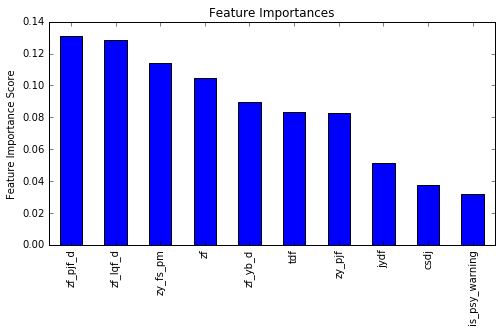

In [186]:
#用默认参数训练出的基线模型(所有特征)
predictors=[x for x in X_new_train.columns]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0,x_train,y_train,predictors,3.6,1,1,skf)

In [197]:
#调节n_estimators参数
param_test1 = {'n_estimators':range(10,201,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=30,
                                  min_samples_leaf=20,max_depth=6,max_features='sqrt',subsample=0.8,random_state=10), 
                       param_grid = param_test1,n_jobs=4,iid=False, cv=5)
gsearch1.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=20,
              min_samples_split=30, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [ ]:
#想查看每次遍历的分数
#gsearch1.cv_results_

In [198]:
#查看当前调参的最优结果
gsearch1.best_params_,gsearch1.best_score_

({'n_estimators': 20}, 0.82914511624598908)

In [260]:
#获得当前模型的最优参数
gsearch1.estimator

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=20,
              min_samples_split=30, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False)

In [189]:
#调节树的深度与参与节点分裂的最少样本数
param_test2 = {'max_depth':range(5,21,1),'min_samples_split':range(100,200,10)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,min_samples_leaf=20,
                                                 max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2,n_jobs=4,iid=False, cv=5)
%time gsearch2.fit(x_train,y_train)

Wall time: 3min 26s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=20,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [190]:
#查看当前调参的最优结果
gsearch2.best_params_,gsearch2.best_score_

({'max_depth': 5, 'min_samples_split': 120}, 0.83016528925619826)

In [191]:
#调节节点分裂的最少样本数与叶子节点的样本本数
param_test3 = {'min_samples_split':range(100,201,10),'min_samples_leaf':range(10,100,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=5,
                                                 max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test3,n_jobs=4,iid=False, cv=5)
%time gsearch3.fit(x_train,y_train)

Wall time: 1min 24s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], 'min_samples_leaf': [10, 20, 30, 40, 50, 60, 70, 80, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [192]:
#查看当前调参的最优结果
gsearch3.best_params_,gsearch3.best_score_

({'min_samples_leaf': 50, 'min_samples_split': 170}, 0.83099173553719008)

In [193]:
#调节参与判断节点分裂的最大特征数
param_test4 = {'max_features':range(5,15,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,min_samples_leaf=50,
                                                max_depth=5,min_samples_split=170, subsample=0.8, random_state=10), 
                       param_grid = param_test4,n_jobs=4,iid=False, cv=5)
gsearch4.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=170, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_features': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [194]:
#查看当前调参的最优结果
gsearch4.best_params_,gsearch4.best_score_

({'max_features': 5}, 0.83099173553719008)

In [195]:
#调节样本采样率
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=5, 
                            min_samples_split=170, min_samples_leaf=50, random_state=10, max_features='sqrt'),
                       param_grid = param_test5,n_jobs=4,iid=False, cv=5)
gsearch5.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=170, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [196]:
#查看当前调参的最优结果
gsearch5.best_params_,gsearch5.best_score_

({'subsample': 0.8}, 0.83099173553719008)

In [228]:
#模型参数
gsearch5.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=5,
              max_features=6, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=10,
              min_samples_split=60, min_weight_fraction_leaf=0.0,
              n_estimators=40, presort='auto', random_state=10,
              subsample=0.75, verbose=0, warm_start=False)

In [ ]:
#调节学习率与树的棵树，当减少学习率时，相对应就成倍增大训练树的棵树（调节最优参数的同时也要防止过拟合）
gbm_tuned_1=GradientBoostingClassifier(learning_rate=0.005, n_estimators=2000,max_depth=7, min_samples_split=160, 
                                         min_samples_leaf=30, max_features='sqrt',subsample=0.8, random_state=10)


Model Report
Accuracy : 0.8372
roc_auc_score : 0.814153
             precision    recall  f1-score   support

          0       0.92      0.04      0.08       820
          1       0.84      1.00      0.91      4020

avg / total       0.85      0.84      0.77      4840

CV Score : Mean - 0.827686 | Std - 0.002003173 | Min - 0.8243802 | Max - 0.8305785


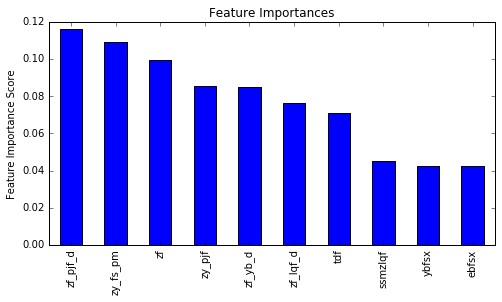

In [197]:
#查看最优模型的模型报告
modelfit(gbm_tuned_1,x_train,y_train,predictors,3.6,1,0,skf)


Model Report
Accuracy : 0.9977
roc_auc_score : 0.999980
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1025
          1       1.00      1.00      1.00      5025

avg / total       1.00      1.00      1.00      6050

CV Score : Mean - 0.8190083 | Std - 0.002024372 | Min - 0.8157025 | Max - 0.8214876


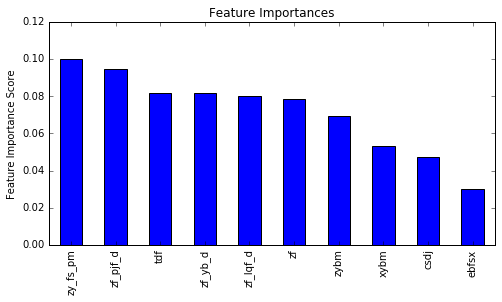

In [300]:
#随机森林(基线模型，即使用默认的参数，以下结果应该过拟合了)
random_forest = RandomForestClassifier(n_estimators=100,random_state=10)
modelfit(random_forest,x_train,y_train,predictors,3.5,1,0,skf)

In [287]:
#调节n_estimators参数
param_test1 = {'n_estimators':range(10,201,10)}
gsearch_rf1 = GridSearchCV(estimator = RandomForestClassifier( min_samples_split=100,min_samples_leaf=20,max_depth=6,
                                  class_weight={'0':3,'1':1},max_features='sqrt',random_state=10), 
                       param_grid = param_test1,n_jobs=4,iid=False, cv=5)
gsearch_rf1.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight={'1': 1, '0': 3},
            criterion='gini', max_depth=6, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=20, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [290]:
#查看当前最优参数
gsearch_rf1.best_params_,gsearch_rf1.best_score_

({'n_estimators': 180}, 0.81735537190082641)

In [294]:
#调节树的最大深度与节点分裂的最少样本数
param_test2 = {'max_depth':range(5,21,1),'min_samples_split':range(100,200,10)}
gsearch_rf2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=180,min_samples_leaf=20,
                                                 max_features='sqrt',class_weight={'0':3,'1':1}, random_state=10), 
                       param_grid = param_test2,n_jobs=4,iid=False, cv=5)
%time gsearch_rf2.fit(x_train,y_train)

Wall time: 7min 56s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight={'1': 1, '0': 3},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [295]:
#查看当前最优参数
gsearch_rf2.best_params_,gsearch_rf2.best_score_

({'max_depth': 5, 'min_samples_split': 120}, 0.81838842975206616)

In [272]:
#调节节点分裂的最少样本数与叶子节点的样本本数
param_test3 = {'min_samples_leaf':range(10,101,10),'min_samples_split':range(100,201,10)}
gsearch_rf3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=180,max_depth=5,
                                                 max_features='sqrt',class_weight={'0':3,'1':1}, random_state=10), 
                       param_grid = param_test3,n_jobs=4,iid=False, cv=5)
%time gsearch_rf3.fit(x_train,y_train)

Wall time: 5min 45s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight={'1': 1, '0': 3.6},
            criterion='gini', max_depth=5, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=190, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], 'min_samples_leaf': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [273]:
#查看当前最优参数
gsearch_rf3.best_params_,gsearch_rf3.best_score_

({'min_samples_leaf': 50, 'min_samples_split': 140}, 0.68677685950413214)

In [276]:
#参与判断的最大特征数
param_test4 = {'max_features':range(5,20,1)}
gsearch_rf4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=190,max_depth=5,min_samples_leaf=50,
                                                 min_samples_split=140,class_weight={'0':3.6,'1':1}, random_state=10), 
                       param_grid = param_test4,n_jobs=4,iid=False, cv=5)
%time gsearch_rf4.fit(x_train,y_train)

Wall time: 1min 3s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight={'1': 1, '0': 3.6},
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=50, min_samples_split=140,
            min_weight_fraction_leaf=0.0, n_estimators=190, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_features': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [278]:
#查看当前最优参数
gsearch_rf4.best_params_,gsearch_rf4.best_score_

({'max_features': 5}, 0.68677685950413214)

In [284]:
#调节下训练树的棵树n_estimators
gsearch_rf5 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=1000,max_depth=5,min_samples_leaf=50,
                                                 min_samples_split=140,class_weight={'0':3.6,'1':1},max_features='sqrt', random_state=10), 
                       param_grid = param_test5,n_jobs=4,iid=False, cv=5)
%time gsearch_rf5.fit(x_train,y_train)

Wall time: 58.6 s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight={'1': 1, '0': 3.6},
            criterion='gini', max_depth=5, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=50, min_samples_split=140,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [280]:
#查看当前最优参数
gsearch_rf5.best_params_,gsearch_rf5.best_score_

({'n_estimators': 100}, 0.6892561983471075)


Model Report
Accuracy : 0.8264
roc_auc_score : 0.707768
             precision    recall  f1-score   support

          0       0.46      0.15      0.23      1025
          1       0.85      0.96      0.90      5025

avg / total       0.78      0.83      0.79      6050

CV Score : Mean - 0.812562 | Std - 0.005131959 | Min - 0.8041322 | Max - 0.8198347


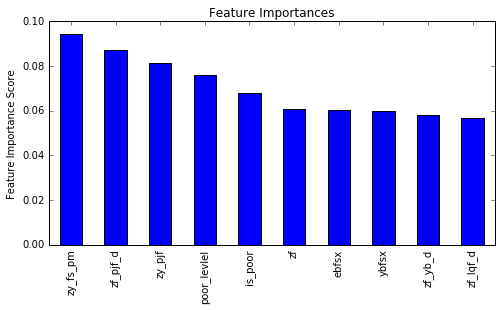

In [289]:
#拟合当前模型，查看结果
modelfit(gsearch_rf1.best_estimator_,x_train,y_train,predictors,1,0.8,0,skf)

In [215]:
#结果输出函数
def learn(x, y, flag,m,n,test_x,test_y):
    # set sample weight（类别权重）
    weight_0=m
    weight_1=n

    weight_list = []
    for j in range(len(y)):
        if y[j] == '0':
            weight_list.append(weight_0)
        if y[j] == '1':
            weight_list.append(weight_1)
    if flag==1:
        #梯度提升决策树（gbm_tuned_1为调参好后的模型，可以改为其它的基线模型如gbm0等）
        clf = gbm_tuned_1.fit(x, y, weight_list)
        prediction_list = clf.predict(test_x)
        accuracy=metrics.accuracy_score(test_y,prediction_list)
    else:
        #随机森林（调参后的模型）因为随机森林里有class_weight参数，可以不拟合weight_list;根据需要选择注释以下其中一项，
        #clf = gsearch_rf5.best_estimator_.fit(x, y, weight_list)
        clf = gsearch_rf5.best_estimator_.fit(x, y)
        
        prediction_list = clf.predict(test_x)
        accuracy=metrics.accuracy_score(test_y,prediction_list)
    return prediction_list,accuracy

In [216]:
#输出结果去准确率
result_pred,accuracy=learn(x_train,y_train,1,3.6,1,x_test,y_test)

In [217]:
#查看'jyzk'预测为0的的个数中多少是正确的
pred=pd.Series(result_pred,index=x_test.index)
ind=[]
for i in pred.index:
    if pred[i]=='0':
        ind.append(i)
pred_all=train_data.ix[ind]
pred_true=pred_all[pred_all['jyzk']==0]
pred_true.head()


,sno,zf,tdf,female,male,ncyj,ncwj,czyj,czwj,ks_is_jf,...,zfdj,zf_yb_d,zf_lqf_d,zf_pjf_d,zy_fs_pm,poor_levlel,is_poor,jyzk,is_psy_warning,zy_pjf
534,2012210723,0,0,0,1,0,0,1,0,1,...,4,0,0,0,208,4.0,0,0,0,0
2115,2012211811,492,512,0,1,0,0,1,0,0,...,2,-28,-3,-29,476,4.0,0,0,0,521
20,2012210032,517,537,0,1,1,0,0,0,0,...,3,-22,-13,-1,248,4.0,0,0,0,518
4244,2012214630,394,414,0,1,0,0,1,0,0,...,3,-7,38,-113,45,4.0,0,0,0,507
433,2012210556,493,493,0,1,0,1,0,0,1,...,3,1,0,-52,41,4.0,0,0,0,545


In [258]:
#查看模型的预测出的各类的人数统计
pred.value_counts()

1    916
0    169
dtype: int64

In [257]:
#预测为0的是正确的个数
true_num_0=len(pred_true)
true_num_0

48

In [231]:
#获取测试集学生的学号
pred_out=pd.Series(train_data.ix[x_test.index]['sno'])
#以测试集学生的学号新建一个表
result=pd.DataFrame(pred_out.values,columns=['sno'],index=range(len(pred_out)))
#预测结果
result['jyzk']=result_pred

In [246]:
result['jyzk'].value_counts()

1    916
0    169
Name: jyzk, dtype: int64

In [248]:
result.head()

,sno,jyzk
0,2012214407,1
1,2012215891,1
2,2012210206,1
3,2012213186,1
4,2012210577,1


In [259]:
#保存数据
result.to_csv('output_result/result.csv',index=False)